In [1]:
import numpy as np
%matplotlib inline
import pprint
import os

In [2]:
# import pymatgen.core

In [3]:
import pandas as pd
import pathlib

In [4]:
# current working directory
print(pathlib.Path().absolute())

/home/samariam/projects/synth/heuristics_analysis


Schent results

In [5]:
# crysdf = pd.read_pickle('/home/samariam/projects/chemheuristics/reports/cotraining_0/fullData0_100ep15')

In [6]:
# crysdf = pd.read_pickle('/home/samariam/projects/chemheuristics/cotraining_schnet_new_res_log/res_df/cotraining_schnet_new0_100ep15tmp')
crysdf = pd.read_pickle('/home/samariam/projects/chemheuristics/cotraining_schnet_new_res_log/res_df/cotraining_schnet_new0_100ep15')

In [7]:
crysdf.tail()

,crystal_id,atoms,material_id,theoretical,formation_energy_per_atom,energy_above_hull,target_pd,targets,pred_0,pred_1,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
42117,29024,"(Atom('Li', [-1.041380862, 0.00062981479999992...",13436,True,-0.069603,0.000000,0,{'synth': [0]},0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
42118,13410,"(Atom('In', [0.7137779929999999, 0.88223775, 1...",13319,True,-0.073609,0.013040,1,{'synth': [1]},NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
42119,12307,"(Atom('O', [-4.2102948591, -1.2376739618999997...",19122,True,-0.113474,0.000000,1,{'synth': [1]},NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42120,34498,"(Atom('Ca', [5.355955613084001, -4.88713827054...",1346296,True,-0.047005,0.028558,0,{'synth': [0]},1.0,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
42121,11568,"(Atom('Cr', [2.299113, 2.299113, 1.487873272],...",3868,True,-0.136614,0.006692,1,{'synth': [1]},1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
if (crysdf.shape[0]-crysdf.groupby("material_id").first().shape[0])/crysdf.shape[0] <0.01:
    crysdf = crysdf.groupby("material_id").first()
else:
    print("We have duplicate data.")    

In [9]:
crysdf.columns

Index(['crystal_id', 'atoms', 'theoretical', 'formation_energy_per_atom',
       'energy_above_hull', 'target_pd', 'targets', 'pred_0', 'pred_1',
       'pred_2',
       ...
       'pred_90', 'pred_91', 'pred_92', 'pred_93', 'pred_94', 'pred_95',
       'pred_96', 'pred_97', 'pred_98', 'pred_99'],
      dtype='object', length=107)

In [10]:
crysdf = crysdf[crysdf.formation_energy_per_atom>-10]   #dropping outlier from outdated database.
crysdf = crysdf[crysdf.energy_above_hull<10]   #dropping outliers for better visualization.

In [11]:
crysdf.shape

(41962, 107)

In [12]:
crysdf.set_index(crysdf.index.map(str), drop=True, inplace=True)

In [13]:
# new_labels_path = '/home/samariam/projects/chemheuristics/data/schnet_0.pkl'
# cotrain_df0 = pd.read_pickle(new_labels_path)
new_labels_alignn = '/home/samariam/projects/chemheuristics/data/alignn_0.pkl'
cotrain_df0 = pd.read_pickle(new_labels_alignn)
cotrain_df0 = cotrain_df0.rename(columns={"target":"original_target"})

In [14]:
if (cotrain_df0.shape[0]-cotrain_df0.groupby("material_id").first().shape[0])/cotrain_df0.shape[0] <0.01:
    cotrain_df0 = cotrain_df0.groupby("material_id").first()
else:
    print("We have duplicate data.")    

In [15]:
# common_index = set(cotrain_ali.index).intersection(cotrain_df0.index)
# cotrain_df0 = cotrain_df0.loc[common_index]
# cotrain_ali = cotrain_ali.loc[common_index]
# (cotrain_ali.target==cotrain_df0.original_target).sum()

In [16]:
cotrain_df0.original_target.tail()

material_id
mp-984806    1
mp-9870      1
mp-9890      1
mp-995191    1
mp-999539    1
Name: original_target, dtype: int64

In [17]:
cotrain_df0.shape[0], crysdf.shape[0], #origdf.shape[0]

(41975, 41962)

In [18]:
sum(crysdf.target_pd==1), sum(cotrain_df0.original_target==1)

(15766, 10280)

In [19]:
crysdf['targets'].map(lambda x: x["synth"]).sum()

array([15766])

In [20]:
crysdf = crysdf.join(cotrain_df0.original_target)    

In [21]:
type(crysdf.index[0])  #should be string

str

In [22]:
crysdf.columns

Index(['crystal_id', 'atoms', 'theoretical', 'formation_energy_per_atom',
       'energy_above_hull', 'target_pd', 'targets', 'pred_0', 'pred_1',
       'pred_2',
       ...
       'pred_91', 'pred_92', 'pred_93', 'pred_94', 'pred_95', 'pred_96',
       'pred_97', 'pred_98', 'pred_99', 'original_target'],
      dtype='object', length=108)

In [23]:
pred_columns = []
score_columns = []
num_iter =100
# num_iter =21
epoch_num = 15
for it in range(num_iter):
    pred_col_name = 'pred_'+str(it)
    pred_columns.append(pred_col_name)
    
    # score_col_name = 'pred_score'+str(it)
    # score_columns.append(score_col_name)

Preds = crysdf[pred_columns]

In [24]:
Preds.head(2)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
material_id,,,,,,,,,,,,,,,,,,,,,
1607,NaN,1.0,NaN,NaN,0.0,NaN,NaN,1.0,NaN,NaN,...,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,0.0
1609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [25]:
def scoreFunc(x):
    iter_num = sum(x.notna())
    if iter_num == 0:
        return np.nan, iter_num
    res = x.sum()
    score = res/iter_num
    return score, iter_num

In [26]:
crysdf['Preds'] = Preds.apply(scoreFunc, axis=1)

crysdf[['Preds', 'iter_num']] = crysdf.Preds.tolist()

# res_df = crysdf[crysdf.Preds.notna()].drop(columns=[*pred_columns,*score_columns])  #selecting data with prediction values
res_df = crysdf[crysdf.Preds.notna()].drop(columns=[*pred_columns])  #selecting data with prediction values

edf = res_df[res_df.original_target==1]
tdf = res_df[res_df.original_target==0]

# %%
true_positive_rate = sum(edf.Preds>=.5)/edf.shape[0]
unlabeled_synth_frac = sum(tdf.Preds>=.5)/tdf.shape[0]

In [27]:
print('Our true positive rate is {:.1f}% after {} iterations of {} epochs.'.format(true_positive_rate*100, num_iter, epoch_num))

Our true positive rate is 98.4% after 100 iterations of 15 epochs.


In [28]:
unlabeled_synth_frac

0.20116157949559674

In [29]:
coedf = res_df[res_df.target_pd==1]
cotdf = res_df[res_df.target_pd==0]

# %%
cotrue_positive_rate = sum(coedf.Preds>=.5)/coedf.shape[0]
counlabeled_synth_frac = sum(cotdf.Preds>=.5)/cotdf.shape[0]

In [30]:
cotrue_positive_rate, counlabeled_synth_frac

(0.9757691087852839, 0.04210566498702092)

In [31]:
(tdf.classPred == tdf.target_pd).sum()/len(tdf)

AttributeError: 'DataFrame' object has no attribute 'classPred'

In [ ]:
(edf.classPred == edf.target_pd).sum()/len(edf) #==(edf.classPred == edf.original_target).sum()/len(edf) #becasue the positive labels didn't change

0.97568093385214

In [32]:
1-(tdf.classPred == tdf.original_target).sum()/len(tdf)

AttributeError: 'DataFrame' object has no attribute 'classPred'

In [33]:
res_df.target_pd.sum()

15765

In [34]:
(cotrain_df0.original_target).sum()

10280

In [36]:
res_dir = "/home/samariam/projects/synth/heuristics_analysis"
res_df.to_pickle(os.path.join(res_dir, '_coSchAl1.pkl'))

In [175]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [176]:
# edf = experimental_df.copy()
# del experimental_df
# tdf = theoretical_df.copy()
# del theoretical_df

In [177]:
len(tdf), len(edf)

(31681, 10280)

In [178]:
# edf.head(2)
# tdf.head(2)

In [179]:
edf['classPred'] = edf.Preds.map(lambda x: 1 if x>.5 else 0)
tdf['classPred'] = tdf.Preds.map(lambda x: 1 if x>.5 else 0)

/tmp/ipykernel_3141504/1033994955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['classPred'] = edf.Preds.map(lambda x: 1 if x>.5 else 0)
/tmp/ipykernel_3141504/1033994955.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['classPred'] = tdf.Preds.map(lambda x: 1 if x>.5 else 0)


In [240]:
edf.classPred.dropna().sum()/len(edf.dropna())

0.97568093385214

In [241]:
tdf.classPred.dropna().sum()/len(tdf.dropna())

0.17354250181496797

In [180]:
# figpath = "/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn"

In [181]:
# figpath

'/home/samariam/projects/chemheuristics/reports/1st_fulldata_schnet_alignn'

In [182]:
nonzero_pred = tdf[(tdf.Preds>0.01) & (tdf.Preds<0.5)]

In [183]:
len(nonzero_pred)/len(tdf)

0.25936681291625896

/tmp/ipykernel_171010/3598013367.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212,  sharex=ax1,)


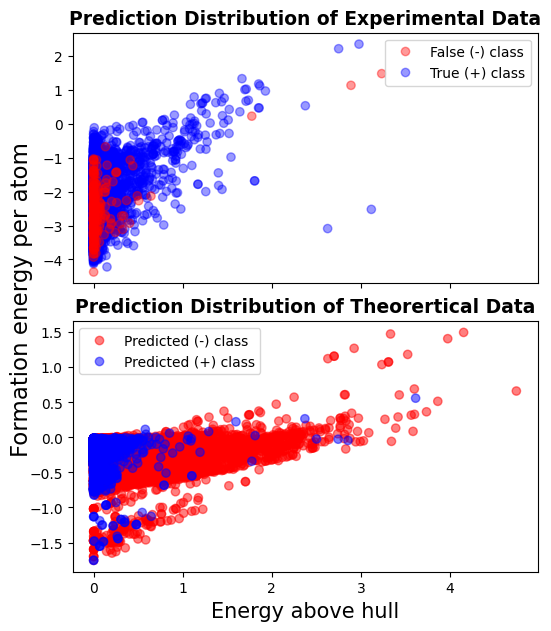

In [57]:
data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

colors = ListedColormap(['r','b'])
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

scatter  = ax1.scatter(edf.sort_values("Preds", ascending=False).energy_above_hull, 
            edf.sort_values("Preds", ascending=False).formation_energy_per_atom,
            c=edf.sort_values("Preds", ascending=False).classPred, 
            cmap = colors,alpha = .4)
ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(212,  sharex=ax1,)
scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).energy_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).classPred, 
            cmap = colors,alpha = .5)

ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=15)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=16.5);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_double_100epoch_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


In [58]:
os.getcwd()

'/home/samariam/projects/chemheuristics/reports/cotraining_0'

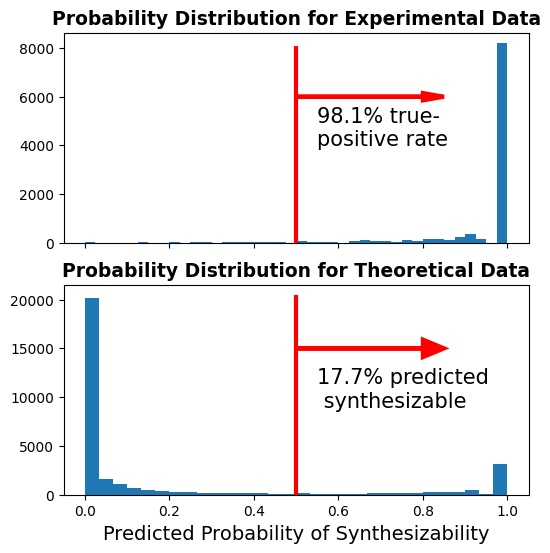

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.hist(edf.Preds, bins=40)
# edf.Preds.hist(bins=40)
ax1.set_title('Probability Distribution for Experimental Data', fontsize=13.5, fontweight='bold')
ax1.vlines(.5, 0,8100, 'r',linewidth=3)
ax1.arrow(.5,6000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=300, head_length=0.05)
ax1.text(.55,4000, '{:.1f}% true- \npositive rate'.format(true_positive_rate*100), fontsize = 15);


plt.xlabel('Predicted Probability of Synthesizability', fontsize=14)

ax2.hist(tdf.Preds,bins=30)
ax2.vlines(.5, 0,20500, 'r',linewidth=3)
ax2.arrow(.5,15000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=1800, head_length=0.05)
ax2.set_title('Probability Distribution for Theoretical Data', fontsize=13.5,fontweight='bold')
ax2.text(.55,9000, '{:.1f}% predicted \n synthesizable'.format(unlabeled_synth_frac*100), fontsize = 15);


# plt.savefig('prob_dist_double.jpg',format='jpg',
plt.savefig('prob_dist_double_100epoch_co0.jpg',format='jpg',
            bbox_inches='tight',dpi=400);


In [70]:
dynamictruePosRates= []
dynamicPredictPosRates = []
never_positive_rate = sum(tdf.Preds==0)/len(tdf)
plot_range = np.linspace(0,1, 25)
for i in plot_range:
    edf['dynamicPred'] = edf.Preds.map(lambda x: 1 if x>i else 0)
    tdf['dynamicPred'] = tdf.Preds.map(lambda x: 1 if x>i else 0)
    dtpr = sum(edf['dynamicPred'])/len(edf)
    dynamictruePosRates.append(dtpr*100)
    dppr = sum(tdf['dynamicPred'])/len(tdf)
    dynamicPredictPosRates.append(dppr*100)
    

/tmp/ipykernel_171010/2732094877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edf['dynamicPred'] = edf.Preds.map(lambda x: 1 if x>i else 0)
/tmp/ipykernel_171010/2732094877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['dynamicPred'] = tdf.Preds.map(lambda x: 1 if x>i else 0)


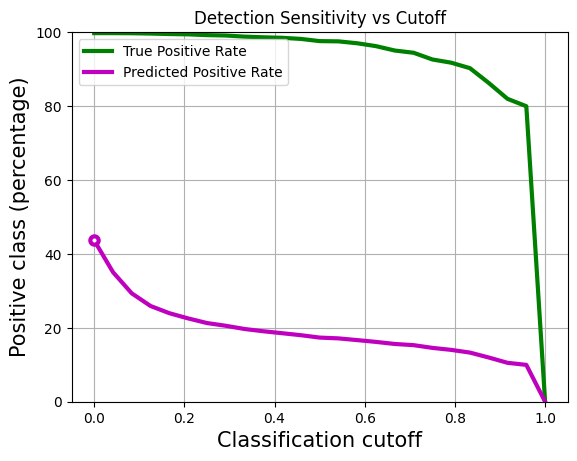

In [72]:
plt.plot(plot_range, dynamictruePosRates, "g", linewidth=3, label ="True Positive Rate")
l, =plt.plot(plot_range, dynamicPredictPosRates,"m", linewidth=3, label ="Predicted Positive Rate")
plt.scatter(plot_range[0], dynamicPredictPosRates[0], marker='o', 
    facecolor='white',  # Change: to opaque color
    edgecolor=l.get_color(),  
    linewidth=l.get_linewidth(),  # Change: match line width
    zorder=10  # Change: raise to higher level.
    )
plt.ylim(0, 100)
plt.grid()
plt.xlabel("Classification cutoff", fontsize = 15)
plt.ylabel("Positive class (percentage)", fontsize = 15)
plt.title("Detection Sensitivity vs Cutoff")
plt.legend()
plt.savefig('detection_sensitivity_cutoff_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);
# ;

In [73]:
tdf.Preds.head()

material_id
1607    0.020000
1609    1.000000
1612    0.818182
1618    0.040000
1623    1.000000
Name: Preds, dtype: float64

In [74]:
tdf["mid_class_pred_sch"] = tdf.classPred.copy()
tdf.mid_class_pred_sch[(tdf.Preds>0.01) & (tdf.Preds<0.5)] = 0.5

/tmp/ipykernel_171010/1272160428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf["mid_class_pred_sch"] = tdf.classPred.copy()
/tmp/ipykernel_171010/1272160428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf.mid_class_pred_sch[(tdf.Preds>0.01) & (tdf.Preds<0.5)] = 0.5
/tmp/ipykernel_171010/1272160428.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf.mid_class

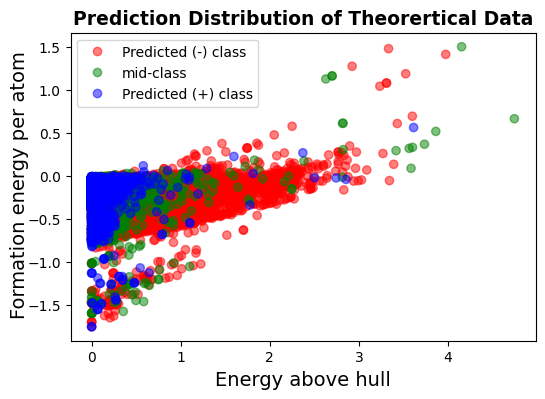

In [76]:

data_classes_t = ['Predicted (-) class', 'mid-class', 'Predicted (+) class']


colors = ListedColormap(['r','g','b'])
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))


scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).energy_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).mid_class_pred_sch, 
            cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred.sort_values("Preds", ascending=False).energy_above_hull, 
#             nonzero_pred.sort_values("Preds", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred.sort_values("Preds", ascending=False).classPred, 
#             cmap = "Accent",alpha = .4)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=14)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=14);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_non_negative_labels_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


<function PU_alignn_analysis.pu_report(output_dir: str = None)>

Alignn results

In [184]:
alignndf = pd.read_pickle('/home/samariam/projects/chemheuristics/reports/cotraining_0/cotrain_alignn_from_schnet_0.pkl')

In [185]:
alignndf = alignndf.rename(columns={"avg_prediction":"avg_prediction_alignn",
                         "prediction":"prediction_alignn",
                         "target":"co_target"})

In [186]:
alignndf.columns

Index(['avg_prediction_alignn', 'prediction_alignn', 'co_target',
       'original_target'],
      dtype='object')

In [187]:
# alignndf = pd.DataFrame()
# alignndf['avg_prediction_alignn'] = alignnraw.groupby('material_id').prediction.mean()
# alignndf['prediction_alignn'] = alignndf['avg_prediction_alignn'].map(round)
# alignndf['target'] = alignnraw.groupby('material_id').target.first()

In [188]:
crysdf.reset_index(inplace=True)
alignndf.reset_index(inplace=True)

In [189]:
# for i in range(len(crysdf)):
#     crysdf.material_id[i]=str(crysdf.material_id[i])

In [190]:
alignndf.shape

(41962, 5)

In [191]:
alignndf.tail()

,material_id,avg_prediction_alignn,prediction_alignn,co_target,original_target
41957,mp-984806,1.0,1,1,1.0
41958,mp-9870,1.0,1,1,1.0
41959,mp-9890,0.0,0,1,1.0
41960,mp-995191,0.8,1,1,1.0
41961,mp-999539,0.0,0,1,1.0


In [205]:
bigdf = crysdf.drop(columns="original_target").merge(alignndf, on="material_id")

In [206]:
bigdf.drop(columns=Preds.columns, inplace=True)

In [202]:
alignndf.head()

,material_id,avg_prediction_alignn,prediction_alignn,co_target,original_target
0,10001,0.833333,1,1,0.0
1,10002,0.250000,0,0,0.0
2,10003,0.880952,1,0,0.0
3,10009,0.956522,1,0,0.0
4,10010,0.634146,1,0,0.0


In [226]:
tdf.original_target.sum()

0

In [227]:
edf.head()

,crystal_id,atoms,theoretical,formation_energy_per_atom,energy_above_hull,target_pd,targets,original_target,Preds,iter_num,classPred
material_id,,,,,,,,,,,
mp-190,9790,"(Atom('O', [-1.8825836311992608, 3.76514648035...",False,-2.136340,0.000000,1,{'synth': [1]},1,1.000000,10.0,1
mp-216,5419,"(Atom('Sc', [2.0132747949999996, 3.487094475, ...",False,-3.969496,0.000000,1,{'synth': [1]},1,1.000000,6.0,1
mp-218,9599,"(Atom('Sm', [2.23275884, 3.867251915, 1.578799...",False,-3.862716,0.000000,1,{'synth': [1]},1,1.000000,5.0,1
mp-223,6658,"(Atom('Ge', [2.7443105007391457, -1.4973574018...",False,-2.077886,0.000035,1,{'synth': [1]},1,0.090909,11.0,0
mp-294,891,"(Atom('U', [1.7446644999999998, 1.110223024625...",False,-3.530939,0.082194,1,{'synth': [1]},1,1.000000,10.0,1


In [214]:
comp = bigdf[bigdf.original_target==0]
comp.co_target.sum(), comp.prediction_alignn.sum()

(568, 5549)

In [228]:
tdf.classPred.shape, comp.prediction_alignn.shape

((31681,), (31681,))

In [232]:
comp.set_index('material_id', inplace=True)

In [235]:
(comp.prediction_alignn == tdf.classPred).sum()/len(tdf)

0.9506644360973454

In [216]:
crysdf.columns

Index(['material_id', 'crystal_id', 'atoms', 'theoretical',
       'formation_energy_per_atom', 'energy_above_hull', 'target_pd',
       'targets', 'pred_0', 'pred_1',
       ...
       'pred_93', 'pred_94', 'pred_95', 'pred_96', 'pred_97', 'pred_98',
       'pred_99', 'original_target', 'Preds', 'iter_num'],
      dtype='object', length=111)

In [210]:
bigEdf = bigdf[bigdf['original_target']==1]
bigTdf = bigdf[bigdf['original_target']==0]

true_positive_rate_alignn = bigEdf['prediction_alignn'].sum()/len(bigEdf)
predicted_positive_rate_alignn = bigTdf['prediction_alignn'].sum()/len(bigTdf)

print("The true positive rate was", round(true_positive_rate_alignn,3))
print("The predicted positive rate for the unlabeled data was", round(predicted_positive_rate_alignn, 3))

The true positive rate was 0.833
The predicted positive rate for the unlabeled data was 0.175


In [211]:
cobigEdf = bigdf[bigdf['co_target']==1]
cobigTdf = bigdf[bigdf['co_target']==0]

psuedo_true_positive_rate_alignn = cobigEdf['prediction_alignn'].sum()/len(cobigEdf)
psuedo_predicted_positive_rate_alignn = cobigTdf['prediction_alignn'].sum()/len(cobigTdf)

print("The psuedo_true positive rate was", round(psuedo_true_positive_rate_alignn,3))
print("The psuedo_predicted positive rate for the unlabeled data was", round(psuedo_predicted_positive_rate_alignn, 3))

The psuedo_true positive rate was 0.835
The psuedo_predicted positive rate for the unlabeled data was 0.163


In [36]:
# bigdf.head(3)

In [212]:
os.getcwd()

'/home/samariam/projects/chemheuristics/reports/cotraining_0'

In [213]:
bigTdf.shape[0], bigEdf.shape[0]

(31681, 10267)

/tmp/ipykernel_3141504/535840900.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(212,  sharex=ax1,)


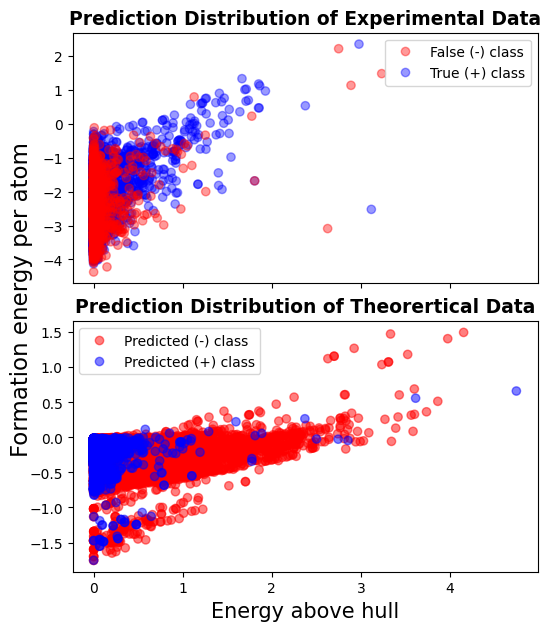

In [55]:
data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

colors = ListedColormap(['r','b'])
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
            bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
            c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
# scatter  = ax1.scatter(bigEdf.energy_above_hull, 
#             bigEdf.formation_energy_per_atom,
#             c=bigEdf.prediction_alignn, 
            cmap = colors,alpha = .4)
ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(212,  sharex=ax1,)
scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
            bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
            c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).prediction_alignn, 
            cmap = colors,alpha = .5)

ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=15)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=16.5);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_alignn_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


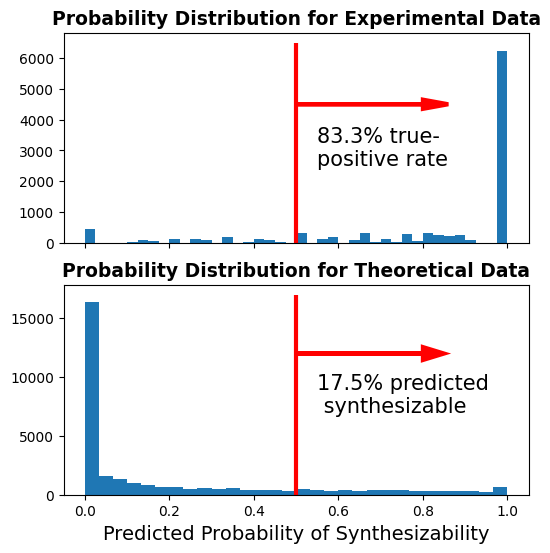

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.hist(bigEdf.avg_prediction_alignn, bins=40)
# edf.Preds.hist(bins=40)
ax1.set_title('Probability Distribution for Experimental Data', fontsize=13.5, fontweight='bold')
ax1.vlines(.5, 0,6500, 'r',linewidth=3)
ax1.arrow(.5,4500,.36,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=300, head_length=0.06)
ax1.text(.55,2500, '{:.1f}% true- \npositive rate'.format(true_positive_rate_alignn*100), fontsize = 15);


plt.xlabel('Predicted Probability of Synthesizability', fontsize=14)

ax2.hist(bigTdf.avg_prediction_alignn,bins=30)
ax2.vlines(.5, 0,17000, 'r',linewidth=3)
ax2.arrow(.5,12000,.35,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=1100, head_length=0.05)
ax2.set_title('Probability Distribution for Theoretical Data', fontsize=13.5,fontweight='bold')
ax2.text(.55,7000, '{:.1f}% predicted \n synthesizable'.format(predicted_positive_rate_alignn*100), fontsize = 15);


# plt.savefig('prob_dist_double.jpg',format='jpg',
plt.savefig('prob_dist_alignn_co0.jpg',format='jpg',
            bbox_inches='tight',dpi=400);


In [48]:
dynamictruePosRatesAl= []
dynamicPredictPosRatesAl = []
never_positive_rate_Al = sum(bigTdf.avg_prediction_alignn==0)/len(bigTdf)
plot_range = np.linspace(0,1, 25)
for i in plot_range:
    bigEdf['dynamicPred'] = bigEdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
    bigTdf['dynamicPred'] = bigTdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
    dtpr = sum(bigEdf['dynamicPred'])/len(bigEdf)
    dynamictruePosRatesAl.append(dtpr*100)
    dppr = sum(bigTdf['dynamicPred'])/len(bigTdf)
    dynamicPredictPosRatesAl.append(dppr*100)
    

/tmp/ipykernel_3141504/1199803182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigEdf['dynamicPred'] = bigEdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
/tmp/ipykernel_3141504/1199803182.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf['dynamicPred'] = bigTdf.avg_prediction_alignn.map(lambda x: 1 if x>i else 0)
/tmp/ipykernel_3141504/1199803182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

''

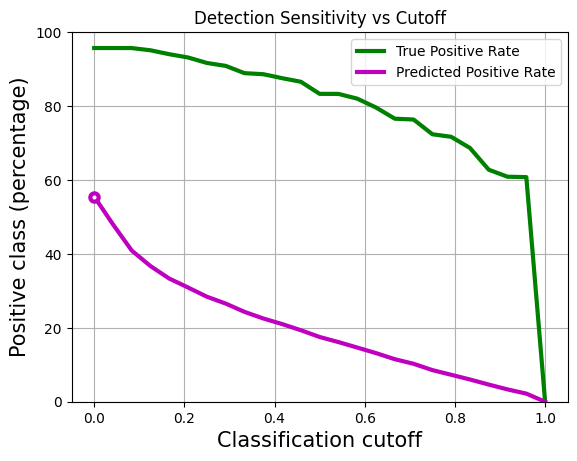

In [63]:
plt.plot(plot_range, dynamictruePosRatesAl, "g", linewidth=3, label ="True Positive Rate")
l, =plt.plot(plot_range, dynamicPredictPosRatesAl,"m", linewidth=3, label ="Predicted Positive Rate")
plt.scatter(plot_range[0], dynamicPredictPosRatesAl[0], marker='o', 
    facecolor='white',  # Change: to opaque color
    edgecolor=l.get_color(),  
    linewidth=l.get_linewidth(),  # Change: match line width
    zorder=10  # Change: raise to higher level.
    )
plt.ylim(0, 100)
plt.grid()
plt.xlabel("Classification cutoff", fontsize = 15)
plt.ylabel("Positive class (percentage)", fontsize = 15)
plt.title("Detection Sensitivity vs Cutoff")
plt.legend()
plt.savefig('detection_sensitivity_cutoff_alignn_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);
;

In [64]:
nonzero_pred_alignn = bigTdf[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)]
len(nonzero_pred_alignn)/len(bigTdf)

0.3751775512136612

In [65]:
bigTdf["mid_class_pred"] = bigTdf.prediction_alignn.copy()
bigTdf.mid_class_pred[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)] = 0.5

/tmp/ipykernel_3141504/3425242755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf["mid_class_pred"] = bigTdf.prediction_alignn.copy()
/tmp/ipykernel_3141504/3425242755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bigTdf.mid_class_pred[(bigTdf.avg_prediction_alignn>0.01) & (bigTdf.avg_prediction_alignn<0.5)] = 0.5
/tmp/ipykernel_3141504/3425242755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

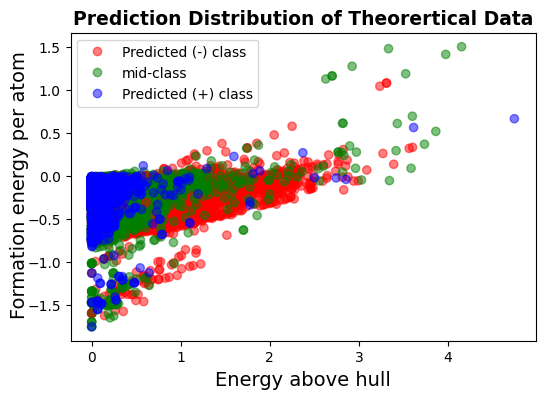

In [66]:
# data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'mid-class', 'Predicted (+) class']
# data_classes_nonzero = ['nonzero']

colors = ListedColormap(['r','g','b'])
fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))

# scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = colors,alpha = .4)
# ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

# ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
# plt.tick_params('x', labelbottom=False);

# ax2 = plt.subplot(  sharex=ax1,)
scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
            bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
            c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).mid_class_pred, 
            cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = "Accent",alpha = .4)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)
# ax2.legend(handles=scatter2.legend_elements()[0], labels=data_classes_nonzero)

ax2.set_xlabel('Energy above hull', fontsize=14)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=14);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_non_negative_labels_alignn_co0.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


'/home/samariam/projects/chemheuristics/alignn'

Result comparison

In [ ]:
# # data_classes_e = ['False (-) class', 'True (+) class']
# data_classes_t = ['Predicted (-) class', 'Predicted (+) class']
# data_classes_nonzero = ['nonzero']

# colors = ListedColormap(['r','b'])
# fig, ax2 = plt.subplots(1, 1, sharex=True, figsize=(6,4))

# # scatter  = ax1.scatter(bigEdf.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
# #             bigEdf.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
# #             c=bigEdf.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
# #             cmap = colors,alpha = .4)
# # ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

# # ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
# # plt.tick_params('x', labelbottom=False);

# ax2 = plt.subplot(  sharex=ax1,)
# scatter  = plt.scatter(bigTdf.sort_values("avg_prediction_alignn", ascending=True).energy_above_hull, 
#             bigTdf.sort_values("avg_prediction_alignn", ascending=True).formation_energy_per_atom,
#             c=bigTdf.sort_values("avg_prediction_alignn", ascending=True).prediction_alignn, 
#             cmap = colors,alpha = .5)
# scatter2  = plt.scatter(nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).energy_above_hull, 
#             nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).formation_energy_per_atom,
#             c=nonzero_pred_alignn.sort_values("avg_prediction_alignn", ascending=False).prediction_alignn, 
#             cmap = "Accent",alpha = .4)
# ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)
# ax2.legend(handles=scatter2.legend_elements()[0], labels=data_classes_nonzero)

# ax2.set_xlabel('Energy above hull', fontsize=14)
# # ax2.set_ylabel('Formation energy per atom', fontsize=12)
# ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

# plt.subplots_adjust(hspace=.15)
# fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
#          rotation='vertical', fontsize=14);

# # plt.savefig('energies_labels_double.jpg', format='jpg',
# # plt.savefig('energies_non_negative_labels_alignn_co0.jpg', format='jpg',
# #             bbox_inches='tight',dpi=400);
